In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing, svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
from skfeature.function.similarity_based import fisher_score

font = {'family' : 'serif',  # 	[ 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ]
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

formaT = ["png","svg"]

In [2]:
def amplifyIndex(train_index,test_index,users,table):
    train_index_users = np.array(users)[train_index]
    test_index_users = np.array(users)[test_index]
    train_index, test_index = [], []
    for user in train_index_users:
        train_index += table.index[table['Patient'] == user].tolist()
    for user in test_index_users:
        test_index += table.index[table['Patient'] == user].tolist()
    return train_index,test_index

def getError(model,train_x, train_y,test_x, test_y,reg = False):
    if model == "SVM":
        clf = svm.SVC(C=0.01, kernel='linear',probability = True) if reg else svm.SVC(C=1,kernel = "linear",probability=True) 
    elif model == "LR":
        clf = LogisticRegression(C=0.1, penalty='l1', solver='liblinear') if reg else LogisticRegression(C=1)
    elif model == "NN":
        clf = MLPClassifier(alpha=10) if reg else MLPClassifier()
    elif model == "kNN":
        clf = KNeighborsClassifier(n_neighbors=1)
    elif model == "DT":
        clf = tree.DecisionTreeClassifier()
    elif model == "RF":
        clf = RandomForestClassifier()
    clf = clf.fit(train_x, train_y)   
    train_error = 1 - clf.score(train_x, train_y)
    test_error = 1 - clf.score(test_x, test_y)
    return train_error,test_error,clf.predict(test_x),clf.predict_proba(test_x)

def errors(models,data,labels,indexes,reg = False):
    err = []
    for train,test in indexes:
        aux = []
        for model in models:
            train_error,test_error,_,_ = getError(model,data[train], labels[train], data[test], labels[test],reg)
            aux += [train_error,test_error]
        err.append(aux)
    return np.array(err)

def readTrainSets(filename):
    train_sets = []
    for line in open(filename):
        new = line.strip()
        train_sets.append([int(elem) for elem in new[new.find("=")+2:-1].split(",")])
    return tuple(train_sets)

def dataFromTable(table):
    # Eliminate Age and Turning time
    data = np.array(table.iloc[:,3:-1])
    labels = np.array(table.iloc[:,-1])
    labels = np.array([types[lab] for lab in labels])
    # scaling data
    scaler = preprocessing.StandardScaler()
    scaler.fit(data)
    return scaler.transform(data),labels

types = {"EPI":1,"EPG2019S":1,"CONTROLES":0,"AsG2019S-":0} 

<h1>Parkinson vs controls </h1>
<p>class 1: EPI + EPG2019S</p>
<p>class 0: CONTROLES + AsG2019S-</p>   
<p>We work with the following data:
<ul>
    <li> Data_v7.csv: 41 PD + 36 Controls, 130 columns: Patient, Age, Turning Time (avg between exp 1 and exp 3), 42 indicators x 3 experiments, Label (130 = 4 + 42*3). Except for Patient, Age and Label we used all variables in 
<a href="https://www.sciencedirect.com/science/article/pii/S1353802022000955">Parkinsonism & Related Disorders</a>
    <li> Data_v8.csv (only the first slice): 41 PD + 36 Controls, 130 columns (same as before)
    <li> Data_v9.csv (all slices: for a patient with n1/1/n2 slices in the 3 experiments, we create n1*n2 lines in this csv): 563 lines for PD + 639 lines for Controls.
    <li> Data_v10.csv (all slices: for a patient with n1 slices in the 1st experiment, we create n1 lines in this csv): only the first experiment but with all slices. 308 in total, 
</ul></p> 

In [3]:
table7 = pd.read_csv("Data_v7.csv", header=0, sep=",")
table8 = pd.read_csv("Data_v8.csv", header=0, sep=",")
table9 = pd.read_csv("Data_v9.csv", header=0, sep=",")
table10 = pd.read_csv("Data_v10.csv", header=0, sep=",")
tables = {"7":table7,"8":table8,"9":table9,"10":table10}
# The list od user IDs
users = table7["Patient"].to_list()

In another notebook, we have selected two equally sized sets of alternating positive and negative examples that we are going to use for plotting the error with increasing sample size.

In [4]:
train_index, test_index, test_set, train_set = readTrainSets("train_sets.txt")

We show them here, for the reference:

In [5]:
train_index = [23, 67, 32, 17, 25, 70, 45, 1, 42, 66, 55, 65, 54, 68, 40, 12, 38, 4, 37, 9, 33, 8, 36, 71, 34, 16, 49, 
               14, 48, 2, 43, 3, 39, 75, 56, 64, 47, 28]
test_index = [21, 63, 57, 0, 44, 6, 50, 15, 52, 62, 27, 18, 53, 72, 20, 76, 41, 60, 51, 10, 58, 5, 24, 11, 19, 69, 31, 
              7, 26, 61, 59, 73, 30, 74, 29, 13, 46, 35]

We have also randmoly selected a train_set and a test_set of 65\% and 35\% of the population (55 examples and 22 examples, respectively), to be used for reporting overall test and train errors. These sets have a similar proportion of positive examples.

In [6]:
test_set = [3, 55, 24, 31, 29, 53, 30, 9, 25, 75, 49, 56, 44, 41, 36, 6, 60, 23, 54, 57, 63, 47, 20, 26, 2, 38, 61]
train_set = [0, 1, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 27, 28, 32, 33, 34, 35, 37, 39, 
             40, 42, 43, 45, 46, 48, 50, 51, 52, 58, 59, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76]

<h3 align="center">Working with the original data</h3>

In [28]:
# Set regularization parameter
reg = False
filename = "Data_v7_"

In [29]:
filename += "reg_" if reg else ""
x_range = range(2,min(len(train_index),len(test_index))+1) 

<h3>This is where the loop starts</h3>

In [42]:
m = re.search('_v(\d{1,2})_',filename)
table = tables[m.group(1)]
if "selected" not in filename:
    data,labels = dataFromTable(table)

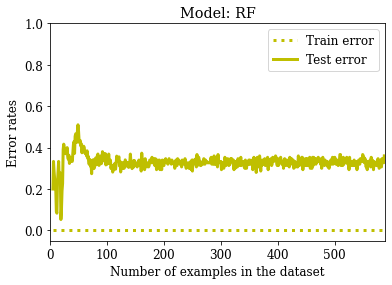

In [43]:
# Get the error rates for increasing training/test size
models = ["SVM","LR","NN","kNN","DT","RF"]
colors = ["b","g","r","c","m","y"]
indexes = []
for n_samples in x_range:   
    train_x,test_x = data[np.array(train_index[:n_samples])],data[np.array(test_index[:n_samples])]
    train_y,test_y = labels[np.array(train_index[:n_samples])],labels[np.array(test_index[:n_samples])]
    indexes.append((np.array(train_index[:n_samples]),np.array(test_index[:n_samples])))
errorRatesInc = errors(models,data,labels,indexes,reg)
j=0 # j=0 for png and j=1 for svg format
for i in range(len(models)):
    plt.clf()
    plt.axis([0, x_range.stop, -0.05, 1])
    plt.title("Model: %s"%models[i])
    plt.plot(x_range,list(errorRatesInc[:,2*i]),c=colors[i], linestyle='dotted',linewidth=3, label="Train error")
    plt.plot(x_range,list(errorRatesInc[:,2*i+1]),c=colors[i],linestyle='solid',linewidth=3, label="Test error")
    plt.legend(loc='best')
    plt.xlabel("Number of examples in the dataset")
    plt.ylabel("Error rates")
    plt.savefig(filename + "%s.%s"%(models[i],formaT[j]), dpi = 400, format = formaT[j])

In [44]:
# Get the error rates for Leave One Out cross validation
models = ["SVM","LR","NN","kNN","DT","RF"]
#models = ["LR"]
indexes = []
for user in users:
    train = np.array(table.index[table['Patient'] != user].tolist())
    test = np.array(table.index[table['Patient'] == user].tolist())  
    indexes.append((train,test))
errorRatesLOO = errors(models,data,labels,indexes,reg)
print("    " + "           ".join(models))
print("train  test   "*6)
print("  ".join(["%.3f"%e for e in np.sum(errorRatesLOO,axis=0)/len(errorRatesLOO)]))

    SVM           LR           NN           kNN           DT           RF
train  test   train  test   train  test   train  test   train  test   train  test   
0.184  0.330  0.199  0.279  0.112  0.293  0.000  0.388  0.000  0.310  0.000  0.314


In [45]:
# Get the error rates for train_set and test_set
models = ["SVM","LR","NN","kNN","DT","RF"]
indexes = [(np.array(train_set),np.array(test_set))]
errorRatesTrainTest = errors(models,data,labels,indexes,reg)
print("    " + "           ".join(models))
print("train  test   "*6)
print("  ".join(["%.3f"%e for e in np.sum(errorRatesTrainTest,axis=0)/len(errorRatesTrainTest)]))

    SVM           LR           NN           kNN           DT           RF
train  test   train  test   train  test   train  test   train  test   train  test   
0.144  0.299  0.164  0.290  0.478  0.551  0.000  0.393  0.000  0.346  0.000  0.299


<h3>This is where the loop ends</h3>

<h1> 1. Feature selection </h1>

In [14]:
# Select attributes
cols = table7.columns.to_list()[3:45]
print(cols)

['Speed1', 'StepLengthMean1', 'StepTimeMean1', 'StepTimeStd1', 'StepTimeVariability1', 'StepTimeAsymmetry1', 'StrideTimeMean1', 'StrideTimeStd1', 'StrideTimeVariability1', 'HipAmplMean1', 'HipAmplStd1', 'HipAmplVariability1', 'HipAmplAsymmetry1', 'AND_StepTimeMean1', 'NAD_StepTimeMean1', 'AND_StepTimeVariability1', 'NAD_StepTimeVariability1', 'AND_HipAmplMean1', 'NAD_HipAmplMean1', 'AND_HipAmplVariability1', 'NAD_HipAmplVariability1', 'AND_ArmAmplMean1', 'NAD_ArmAmplMean1', 'AND_ArmAmplVariability1', 'NAD_ArmAmplVariability1', 'AND_ArmJerk1', 'NAD_ArmJerk1', 'AND_ElbowAmplMean1', 'NAD_ElbowAmplMean1', 'AND_ElbowAmplVariability1', 'NAD_ElbowAmplVariability1', 'ArmAmplMean1', 'ArmAmplStd1', 'ArmAmplVariability1', 'ArmAmplAsymmetry1', 'ElbowAmplMean1', 'ElbowAmplStd1', 'ElbowAmplVariability1', 'ElbowAmplAsymmetry1', 'TrunkRotationAmplitude1', 'TrunkRotationAsymmetry1', 'TrunkJerk1']


- PD patients and controls showed differences in speed, stride/step length and arm swing amplitude, variability and asymmetry in all three tasks.

In [15]:
selected_cols1 = cols[:2]+cols[31:32]+cols[33:35]
select = [name.replace("1",str(exp))  for exp in range(1,4) for name in selected_cols1]

- Also, in fast walking and dual task situation, PD patients showed greater step and stride time

In [16]:
selected_cols2 = cols[2:3]+cols[6:7]
select += [name.replace("1",str(exp))  for exp in range(2,4) for name in selected_cols2]

In [17]:
print(" ".join(select))

Speed1 StepLengthMean1 ArmAmplMean1 ArmAmplVariability1 ArmAmplAsymmetry1 Speed2 StepLengthMean2 ArmAmplMean2 ArmAmplVariability2 ArmAmplAsymmetry2 Speed3 StepLengthMean3 ArmAmplMean3 ArmAmplVariability3 ArmAmplAsymmetry3 StepTimeMean2 StrideTimeMean2 StepTimeMean3 StrideTimeMean3


In [18]:
# Get index of selected colums in the original table
table7.columns.get_indexer(select)

array([  3,   4,  34,  36,  37,  45,  46,  76,  78,  79,  87,  88, 118,
       120, 121,  47,  51,  89,  93], dtype=int64)

In [19]:
# Since data eliminates the first three columns, we have to substract 3 from all these elements
select_indexes = table7.columns.get_indexer(select)-3
select_indexes

array([  0,   1,  31,  33,  34,  42,  43,  73,  75,  76,  84,  85, 115,
       117, 118,  44,  48,  86,  90], dtype=int64)

In [20]:
select_data = data[:,select_indexes]

In [21]:
select_data.shape

(77, 19)

In [22]:
assert(select_data.shape == (77,19))

In [23]:
reg, filename, data = False, "Data_v7_selected_", select_data
x_range = range(2,min(len(train_index),len(test_index))+1) 

<h3>TO DO: Repeat the loop with the new data</h3>

<h1> 2. Introduce regularization </h1>

In a separate notebook, we have chosen the best regularization parameters by applying 
5-fold cross-validation on the training set. 

The best parameters were:
- SVM: (C = 0.01, penalty = 'l2')
- LR: (solver = 'liblinear', C = 0.1, penalty = 'l1')
- NN: (alpha = 10, penalty = 'l2')

<h3>TO DO: Repeat from "Working with original data" and set regularization parameter to "True"</h3>

<h1> 3. Increase size of dataset</h1>

<h2> First idea</h2>

In [34]:
filename = "Data_v9_"
x_range = range(17,min(len(train_index),len(test_index))+1)
m = re.search('_v(\d{1,2})_',filename)
table = tables[m.group(1)]

We have to define new train_index and test_index and train_set and test_set based on the bigger dataset

In [35]:
train_index, test_index, test_set, train_set = readTrainSets("train_sets.txt")
train_index,test_index = amplifyIndex(train_index,test_index,users,table)
train_set,test_set = amplifyIndex(train_set,test_set,users,table)

<h3>TO DO: Repeat the loop with the new data</h3> 

<h2> Second idea </h2>

In [40]:
filename = "Data_v10_"
x_range = range(5,min(len(train_index),len(test_index))+1)
m = re.search('_v(\d{1,2})_',filename)
table = tables[m.group(1)]

We have to define new train_index and test_index and train_set and test_set based on the bigger dataset

In [41]:
train_index, test_index, test_set, train_set = readTrainSets("train_sets.txt")
train_index,test_index = amplifyIndex(train_index,test_index,users,table10)
train_set,test_set = amplifyIndex(train_set,test_set,users,table10)

<h3>TO DO: Repeat the loop with the new data</h3> 

<h1>4. Print statistics for the best model<h1>

In [46]:
filename = "Data_v7_"
m = re.search('_v(\d{1,2})_',filename)
table = tables[m.group(1)]
data,labels = dataFromTable(table)

In [47]:
train_index, test_index, test_set, train_set = readTrainSets("train_sets.txt")
train_x, train_y, test_x, test_y = data[train_set], labels[train_set], data[test_set], labels[test_set]

In [48]:
model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear') 
#model = tree.DecisionTreeClassifier(max_depth=1)
#model = RandomForestClassifier(max_depth=1, max_features=None)   
#model = MLPClassifier(alpha=33, early_stopping=True, hidden_layer_sizes=(50,),learning_rate='adaptive', n_iter_no_change=20000)

In [49]:
model.fit(train_x,train_y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [50]:
# Compute metrics
from math import sqrt
from sklearn import metrics
from sklearn.metrics import accuracy_score
toprint = ""
predictions = model.predict_proba(test_x)[:,1]
pred_int = np.squeeze(np.rint(predictions)).astype(int)
pred_train  = model.predict_proba(train_x)[:,1]
pred_int_train = np.squeeze(np.rint(pred_train)).astype(int)
accuracy = metrics.accuracy_score(labels[test_set],pred_int)
conf_matrix = list(zip(labels[test_set], pred_int))
auc = metrics.roc_auc_score(labels[test_set],predictions)
toprint += "Training sample size %s\n"%len(train_set)
toprint += "Test sample size %s\n"%len(test_set)
toprint += "Number of positive examples in test %s\n"%np.sum(labels[test_set])
toprint += "Train accuracy %.3f\n"%accuracy_score(labels[train_set],pred_int_train)
toprint += "Test accuracy %.3f\n"%accuracy
toprint += "AUC %.3f\n"%auc
sen = conf_matrix.count((1,1))/np.sum(labels[test_set])
toprint += "Sensitivity/recall %.2f\n"%sen
spec = conf_matrix.count((0,0))/list(labels[test_set]).count(0)
toprint += "Specificity %.2f\n"%spec
prec = conf_matrix.count((1,1))/np.sum(pred_int)
toprint += "Precision %.2f\n"%prec
    #We can calculate the 95% confidence interval (z = 1.96) as follows: 
    #https://machinelearningmastery.com/confidence-intervals-for-machine-learning/
error = 1 - accuracy
interval = 1.96 * sqrt(error * accuracy / len(test_set))
toprint +="95-confidence interval %.3f\n" % interval

In [51]:
print(toprint)

Training sample size 50
Test sample size 27
Number of positive examples in test 14
Train accuracy 0.800
Test accuracy 0.815
AUC 0.879
Sensitivity/recall 0.71
Specificity 0.92
Precision 0.91
95-confidence interval 0.147



In [52]:
conf_matrix.count((1,0))

4

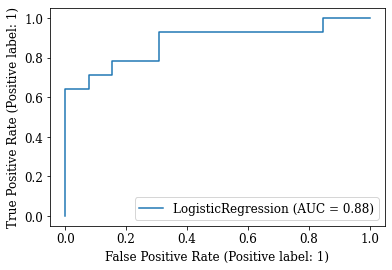

In [53]:
j=0
metrics.plot_roc_curve(model, test_x, test_y) 
#plt.savefig("ROC.%s"%formasT[j], dpi = 400, format = formasT[j])